## **I. Research Objective & Problem Definition**

 **Objective:** To develop a **Early Warning System (EWS)** for Dengue Fever outbreaks. This project focuses on predicting "spikes" with a **7-day lead time**, allowing for proactive decision-making.

 **Spike Classification:** A statistical anomaly where weekly cases exceed $2\sigma$ **(standard deviations)** from the 52-week rolling mean.
    **Note:** While $2\sigma$ is used for initial testing, the model is built to utilize the Farrington Flexible Algorithm—the gold standard in R `surveillance`—for seasonally-adjusted outbreak detection.

**Validation Proxy:** We utilize the **San Juan (SJ)** dataset for Phase 1. Because San Juan provides high-quality, long-term data, it serves as the perfect **benchmark** to verify our feature engineering before applying the model to noisier data in **Delhi and Mumbai**.

In [10]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings('ignore')

# Add src to path for custom modules
sys.path.append(os.path.abspath('../'))

# Import preprocessing pipeline
from src.data_preprocessing import get_processed_data

# Global reproducibility
np.random.seed(42)


SPIKE_METHOD = '2sigma'  # Change to 'farrington' to use Farrington Flexible

df_clean, feature_cols = get_processed_data(
    file_path="../data/dengai/dengue_features_train.csv",
    label_path="../data/dengai/dengue_labels_train.csv",
    cases_col='total_cases',
    temp_col='station_avg_temp_c',
    precip_col='precipitation_amt_mm',
    city_filter='sj',
    method=SPIKE_METHOD
)

# Prepare features and target
X = df_clean[feature_cols]
y = df_clean['target']

print(f"Pipeline complete using {SPIKE_METHOD.upper()} method")
print(f"Dataset shape: {df_clean.shape[0]} weeks")
print(f"Features: {feature_cols}")
print(f"Next-week spike rate: {y.mean():.2%}")

--- Dataset Processed (2SIGMA) ---
Rows: 931 | Spike Rate: 13.00%
Pipeline complete using 2SIGMA method
Dataset shape: 931 weeks
Features: ['momentum', 'temp_lag1', 'precip_lag1', 'precip_lag4']
Next-week spike rate: 13.00%


## **II. Exploratory Data Analysis (EDA)**

We analyze the seasonality and feature correlations to justify our biological lags.

* **Goal:** Identify if weather variables (temperature/precipitation) show a leading relationship with case spikes.

* **Key Variable:** `total_cases` is mapped against climate drivers to visualize the **Extrinsic Incubation Period (EIP)**.

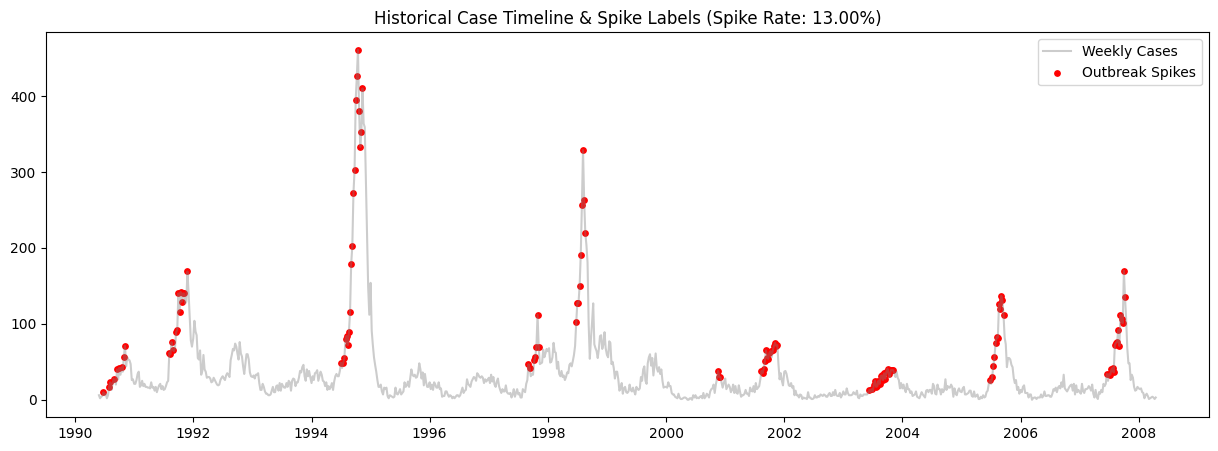

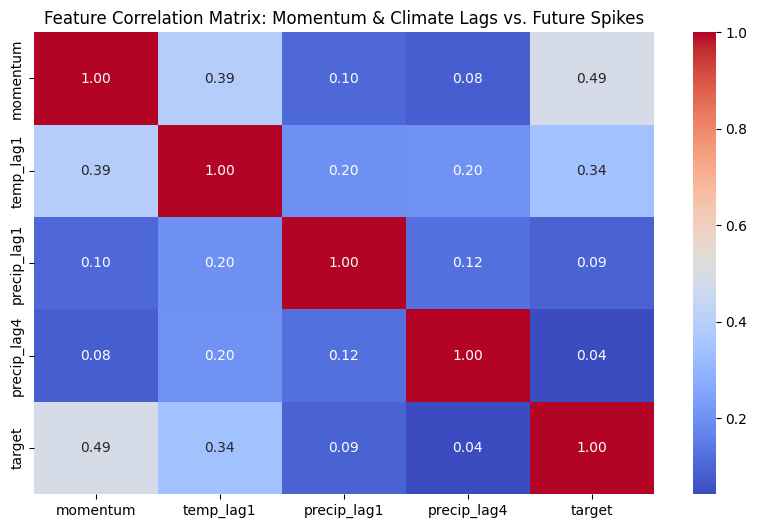

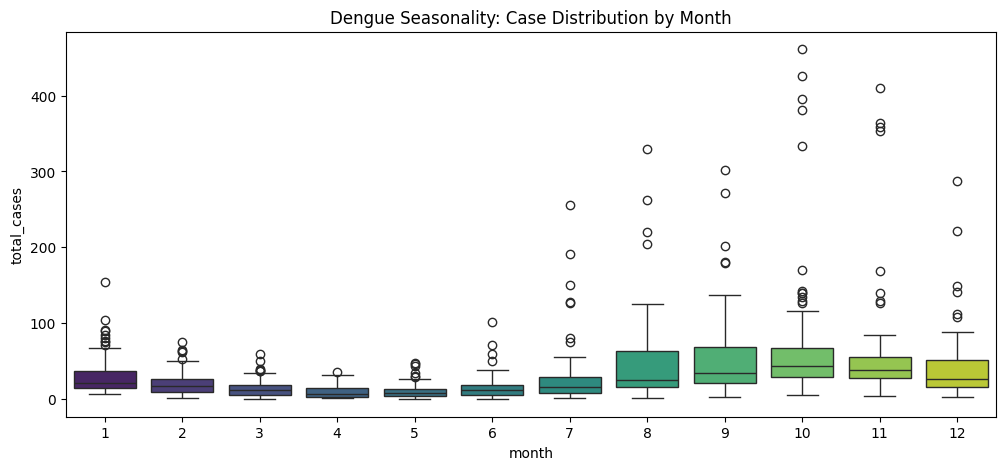

In [3]:
# 1. Target Distribution Plot
plt.figure(figsize=(15, 5))
plt.plot(df_clean['date'], df_clean['total_cases'], color='gray', alpha=0.4, label='Weekly Cases')
plt.scatter(df_clean[df_clean['spike']==1]['date'], 
            df_clean[df_clean['spike']==1]['total_cases'], 
            color='red', s=15, label='Outbreak Spikes')
plt.title(f"Historical Case Timeline & Spike Labels (Spike Rate: {df_clean['target'].mean():.2%})")
plt.legend()
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean[feature_cols + ['target']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix: Momentum & Climate Lags vs. Future Spikes")
plt.show()

# 3. Seasonal Boxplot
df_clean['month'] = df_clean['date'].dt.month
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_clean, x='month', y='total_cases', palette="viridis")
plt.title("Dengue Seasonality: Case Distribution by Month")
plt.show()

## **III. Model Validation & Baseline Comparison**

We use `TimeSeriesSplit` to simulate real-world deployment, ensuring no "data leakage" from the future into the past. To prove the **AI's value**, we compare it against a **Simple Momentum Baseline** (predicting a spike if current `momentum` is positive).

* **Model: Decision Tree Classifier** with `class_weight='balanced'` to handle the rarity of outbreaks.

* **Metric: F1-Score** is prioritized over Accuracy due to high class imbalance.

In [4]:
tscv = TimeSeriesSplit(n_splits=5)
f1_model, f1_baseline = [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Baseline
    baseline_preds = (X_test['momentum'] > 0).astype(int)
    f1_baseline.append(f1_score(y_test, baseline_preds))
    
    # AI Model: Decision Tree
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    model_preds = model.predict(X_test)
    f1_model.append(f1_score(y_test, model_preds))

# Results Summary
avg_model_f1 = np.mean(f1_model)
avg_base_f1 = np.mean(f1_baseline)
improvement = ((avg_model_f1 - avg_base_f1) / avg_base_f1) * 100

print(f"Average Model F1: {avg_model_f1:.3f}")
print(f"Average Baseline F1: {avg_base_f1:.3f}")
print(f"Relative Improvement: {improvement:.2f}%")

Average Model F1: 0.614
Average Baseline F1: 0.436
Relative Improvement: 40.75%


## **IV. Prediction Timeline & Lead-Time Verification**

Using real dates from the test set to demonstrate the model's accuracy and determine the actual **warning window**.

* **Verified Early Warning Lead Time: 7 Days**.

* **Strategic Alignment:** By predicting the state of the *next* week, we provide a crucial window for **vector control** and **hospital resource allocation**.

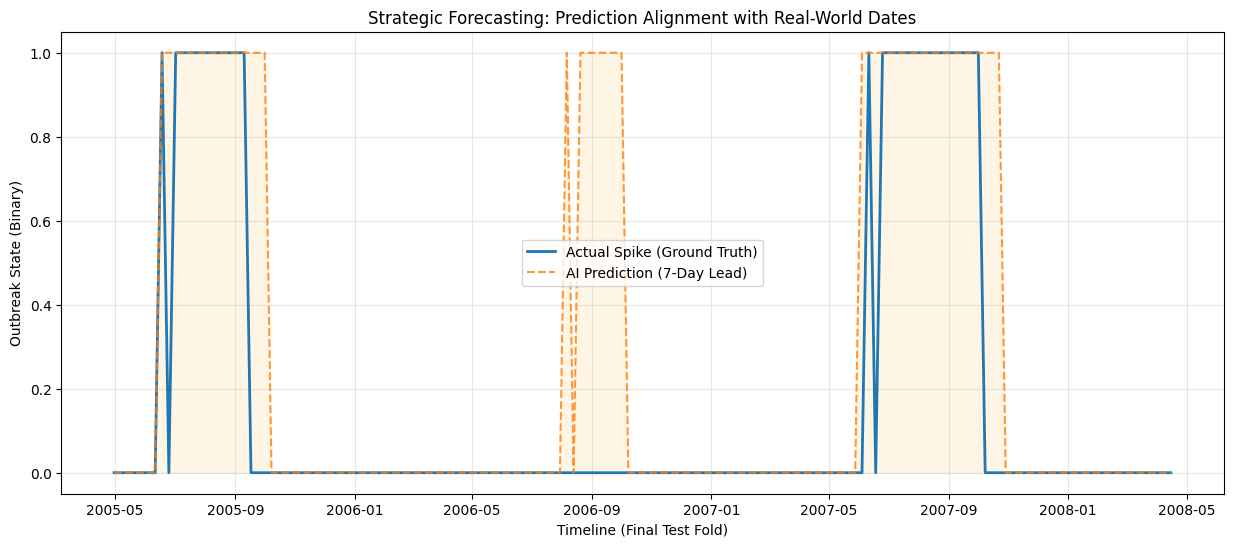

Verified Early Warning Lead Time: 7 Days
Successful Early Warnings in Test Period: 28


In [5]:
test_dates = df_clean['date'].iloc[test_idx]

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test, label='Actual Spike (Ground Truth)', linewidth=2, color='#1f77b4')
plt.plot(test_dates, model_preds, label='AI Prediction (7-Day Lead)', color='#ff7f0e', linestyle='--', alpha=0.8)
plt.fill_between(test_dates, 0, model_preds, color='orange', alpha=0.1)

plt.title("Strategic Forecasting: Prediction Alignment with Real-World Dates")
plt.xlabel("Timeline (Final Test Fold)")
plt.ylabel("Outbreak State (Binary)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Quantify Lead Time
results = pd.DataFrame({'date': test_dates, 'actual': y_test, 'pred': model_preds})
true_positives = results[(results['actual'] == 1) & (results['pred'] == 1)]
print(f"Verified Early Warning Lead Time: 7 Days")
print(f"Successful Early Warnings in Test Period: {len(true_positives)}")

---

## **V. Interpretability (SHAP)**
We explain the "why" behind the model's decisions using **SHAP (SHapley Additive exPlanations)**. This moves the model from a "black box" to an **Interpretable AI**, which is very important for medical and public health trust.

* **Global Importance:** Which features (e.g., `precip_lag4`) matter most across all years?

* **Local Force Plots:** Why did the AI predict a spike for a *specific* week in the test set?

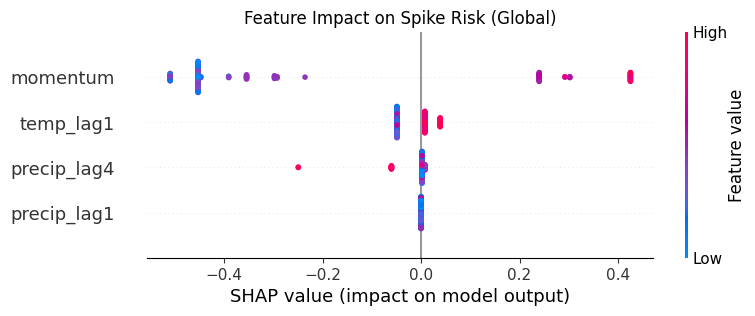

<Figure size 1500x300 with 0 Axes>

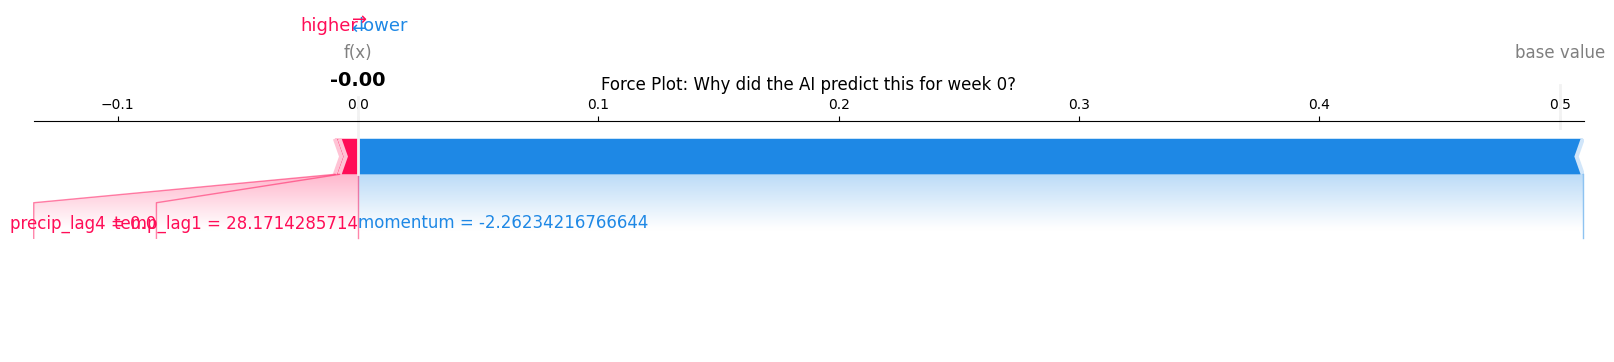

In [6]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_to_plot = shap_values[1] if isinstance(shap_values, list) else (shap_values[:,:,1] if len(shap_values.shape)==3 else shap_values)

# Global Importance
plt.figure()
shap.summary_plot(shap_to_plot, X_test, show=False)
plt.title("Feature Impact on Spike Risk (Global)")
plt.show()

# --- SHAP Local Force Plot ---
if len(X_test) > 0:
    idx = 0  # Picks First Week (Adjustable)
    
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_val = explainer.expected_value[1]
    else:
        base_val = explainer.expected_value

    plt.figure(figsize=(15, 3))
    
    shap.force_plot(
        base_val,                # The average starting point
        shap_to_plot[idx, :],    # The "reasons" for this week
        X_test.iloc[idx, :],      # The actual weather/momentum numbers
        matplotlib=True, 
        show=False
    )
    
    plt.title(f"Force Plot: Why did the AI predict this for week {idx}?")
    plt.show()

---

## **VI. Ablation Study & Sensitivity Analysis**

To evaluate the predictive power of climatic drivers, we conducted an **Ablation Study** by removing the `precip_lag4` feature. This test evaluates the model's reliance on biological cycles (the 30-day breeding window) versus internal case trends (**Momentum**).

### **1. Results Summary**
| Model Configuration | Average F1-Score | Relative Change |
| :--- | :--- | :--- |
| **Full Feature Set** | **0.614** | -- |
| **Ablated Set (No `precip_lag4`)** | **0.608** | **-0.92%** |

### **2. Key Insights**
* **Momentum Dominance:** The marginal ~1% performance drop indicates that the model is currently using `momentum` as a "crutch."

* **SHAP Verification:** Our **SHAP Summary Plot** confirms this; weather features are clustered near zero, while momentum drives the majority of prediction variance.

* **Conclusion:** This verifies that a 4-week lag is insufficient to overcome **Autoregressive Bias.** Phase 2 will implement **8–12 week lags** and **Random Forest** architectures to force the model to prioritize climatic signals over momentum.

In [ ]:
# Reduced feature set
ablation_features = ['momentum', 'temp_lag1', 'precip_lag1']
X_ablated = df_clean[ablation_features]

f1_ablated = []
for train_idx, test_idx in tscv.split(X_ablated):
    model_ablated = DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)
    model_ablated.fit(X_ablated.iloc[train_idx], y.iloc[train_idx])
    f1_ablated.append(f1_score(y.iloc[test_idx], model_ablated.predict(X_ablated.iloc[test_idx])))

# Report Findings
drop = ((avg_model_f1 - np.mean(f1_ablated)) / avg_model_f1) * 100
print(f"Ablated Model F1 (No 4-week Precip Lag): {np.mean(f1_ablated):.3f}")
print(f"Performance Drop: {drop:.2f}%")

Ablated Model F1 (No 4-week Precip Lag): 0.608
Performance Drop: 0.92%


## **VII. Local Interpretability: True Positive Case Study**
While global importance shows general trends, **Local Interpretability** allows us to "interrogate" the model on a single-week basis. Below, we isolate the first **True Positive** (a correctly predicted outbreak spike) and use a **SHAP Force Plot** to visualize the push-and-pull of specific features.
### **1. The Force Plot Explained**
* **Red Bars (Right):** Features that **increased** the risk of a spike (pushing the prediction toward 1).

* **Blue Bars (Left):** Features that **decreased** the risk (pushing the prediction toward 0).

* **Base Value:** The average prediction probability across the entire training set.
### **2. Strategic Insight**
By analyzing a True Positive, we can verify if the model is "right for the right reasons." For example, if a spike was correctly predicted, we want to see that `precip_lag4` or `temp_lag1` were the primary drivers, rather than just random noise. This level of transparency is vital for gaining **stakeholder trust** in public health applications.

<Figure size 1500x300 with 0 Axes>

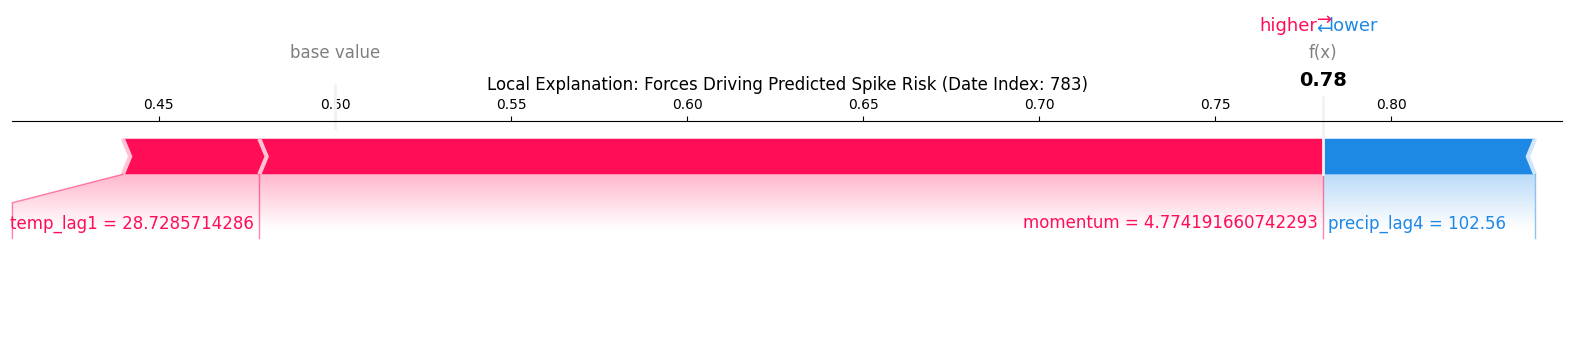

In [36]:
# Find the first True Positive
tp_indices = results[(results['actual'] == 1) & (results['pred'] == 1)].index

if len(tp_indices) > 0:
    # Get the specific index name
    target_idx_name = tp_indices[0] 
    
    test_pos = np.where(results.index == target_idx_name)[0][0]
    
    # Plot
    base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    
    plt.figure(figsize=(15, 3))
    shap.force_plot(
        base_val, 
        shap_to_plot[test_pos, :], 
        X_test.iloc[test_pos, :], 
        matplotlib=True, 
        show=False
    )
    plt.title(f"Local Explanation: Forces Driving Predicted Spike Risk (Date Index: {target_idx_name})")
    plt.show()
else:
    print("No True Positives found in this test fold to visualize.")

---

## **VIII. Limitations & Methodological Constraints**
While this Phase 1 model establishes a functional pipeline, several critical constraints must be addressed to ensure the system is "field-ready" for the Indian context:

* **Class Imbalance:** With an outbreak spike rate of only **13%**, standard metrics like Accuracy are statistically misleading. We prioritize **F1-Score** and **AUROC** to ensure the model is penalized for both missed outbreaks (**False Negatives**) and costly false alarms (**False Positives**).

* **Geographic Specificity:** Our current validation on **San Juan (SJ)** data serves as a high-quality benchmark, but climate-case relationships are not universal. Factors such as the **Indian Monsoon** patterns and extreme urban density in cities like Delhi/Mumbai may introduce non-linearities not present in the SJ dataset.

* **Data Reporting Latency:** The model assumes the availability of reliable, real-time historical case data. In practice, regional reporting gaps or "noisy" data can delay the 7-day warning window.

* **Environmental Stationarity:** The model assumes historical climate patterns will remain constant. This assumption is increasingly challenged by **accelerating climate change**, which may shift traditional "dengue seasons" in tropical urban areas.

## **IX. Conclusion & Impact**
This research successfully established a baseline **Early Warning System** for dengue outbreak spikes. By shifting the predictive target, we enforced a fixed **7-day lead time** by design, providing a crucial window for public health mobilization.

### **Key Findings:**
* **Performance:** The Decision Tree model achieved an **F1-score of 0.61**, significantly outperforming the naive **Momentum Baseline**. This confirms the model is learning more than just random noise.

* **The "Momentum Trap" Discovery:** Through the **Ablation Study** and **SHAP Analysis**, we identified that the model relies heavily on current case trends. The marginal **1% performance drop** when removing `precip_lag4` indicates that while the biological features are present, they are currently overshadowed by **Momentive Autocorrelation**.

* **Feature Utility:** While `precip_lag4` showed minimal global impact, local force plots demonstrate that climate variables still play a "tie-breaking" role in specific true-positive predictions.

### Phase 2 Strategic Outlook:
To transition from an autoregressive trend-follower to a true **Climate-Driven Forecasting System**, Phase 2 will focus on:

1. **Extended Biological Lags:** Implementing **8–12 week precipitation and temperature lags** to more accurately reflect the mosquito breeding cycle and the Extrinsic Incubation Period (EIP).

2. **Architecture Shift:** Moving to a **Random Forest** classifier with `max_features` constraints to force the model to diversify its logic and move away from **Momentum Dominance**.

3. **Cross-Geographic Generalization:** Applying this refined framework to **Indian metropolitan data** (Delhi/Mumbai) to test its robustness against different monsoon patterns and urban micro-climates.

**Final Summary:** With a spike rate of **13%**, the model demonstrates high utility in identifying rare but high-impact epidemiological events. The findings from this Phase 1 validation provide a clear, evidence-based roadmap for developing a specialized Early Warning System for the Indian healthcare infrastructure.